In [2]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git


Cloning into 'uni2ts'...
remote: Enumerating objects: 716, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 716 (delta 159), reused 152 (delta 128), pack-reused 446
Receiving objects: 100% (716/716), 5.22 MiB | 1.30 MiB/s, done.
Resolving deltas: 100% (328/328), done.


## Import the packeges

/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running backtest for RsiBollingerBandsStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


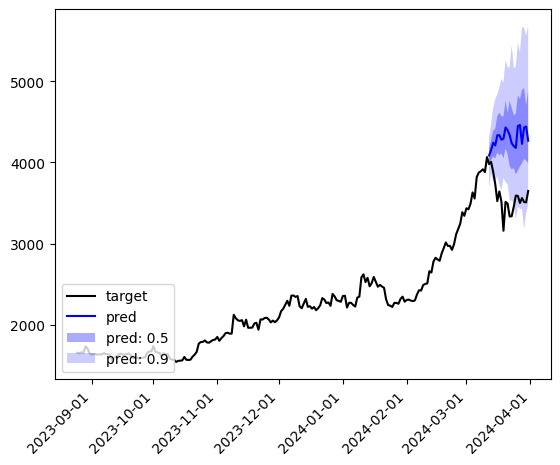

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100044.12


<IPython.core.display.Javascript object>

Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100044.11551171874
Sharpe Ratio: -44.33552762009954
Max Drawdown: 0.178009113397425
Total Trades: 1
Winning Trades: 1
Losing Trades: 0
Total Return: 0.00044105783687816173
Running backtest for MacdStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100927.54
Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100927.54213549806
Sharpe Ratio: -1.2165196237868399
Max Drawdown: 1.3007929155129758
Total Trades: 13
Winning Trades: 4
Losing Trades: 9
Total Return: 0.009232668796317978
Running backtest for StochasticOscillatorStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100922.40
Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100922.39797241212
Sharpe Ratio: -0.8647908600419059
Max Drawdown: 0.34094949414063014
Total Trades: 5
Winning Trades: 3
Losing Trades: 1
Total Return: 0.009181698624275226


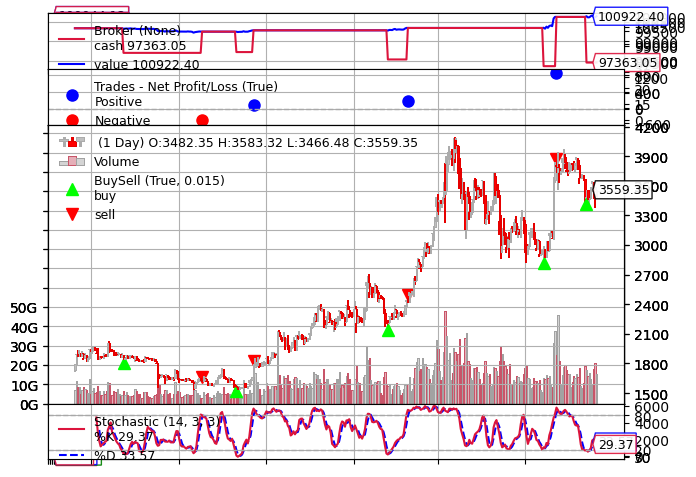

In [1]:
import os
import sys 
import matplotlib.pyplot as plt
root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))
sys.path.append(root_path_scripts)

from forecast_backtest_runner import run_backtest, RsiBollingerBandsStrategy, MacdStrategy, StochasticOscillatorStrategy

if __name__ == "__main__":
    symbol = 'ETH-USD'
    start_date = '2023-06-20'
    end_date = '2024-06-20'
    
    strategies = [RsiBollingerBandsStrategy, MacdStrategy, StochasticOscillatorStrategy]
    
    for strategy in strategies:
        print(f"Running backtest for {strategy.__name__}")
        run_backtest(strategy, symbol, start_date, end_date)
